In [145]:
# Import Libraries

import pandas as pd
from pandas import Series,DataFrame
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pylab
import csv
import datetime
import math
import re
import time
import random

from pandas.tseries.offsets import *
from operator import *

%matplotlib inline

# machine learning
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Setting up PATH to import xgboost
mingw_path = 'C:\\Program Files\\mingw-w64\\x86_64-6.3.0-posix-seh-rt_v5-rev1\\mingw64\\bin'
os.environ['PATH'] = mingw_path + ';' + os.environ['PATH']
import xgboost as xgb



In [146]:
#Utility functions - Source: Chenglong Chen Kaggle forums

def ToWeight(y):
    w = np.zeros(y.shape, dtype=float)
    ind = y != 0
    w[ind] = 1./(y[ind]**2)
    return w

def rmspe(yhat, y):
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean( w * (y - yhat)**2 ))
    return rmspe

def rmspe_xg(yhat, y):
    # y = y.values
    y = y.get_label()
    y = np.exp(y) - 1
    yhat = np.exp(yhat) - 1
    w = ToWeight(y)
    rmspe = np.sqrt(np.mean(w * (y - yhat)**2))
    return "rmspe", rmspe

In [147]:
# Load train, test and store datasets
os.chdir('C:\\LUML\\Kaggle\\Rossmann')
train = pd.read_csv("train.csv")
store  = pd.read_csv("store.csv")
test   = pd.read_csv("test.csv")

C:\Python3.5\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [148]:
# Data Cleansing and Preprocessing

# Convert Date column from object to datetime and sort train and test data based on date

train['Date'] = pd.to_datetime(train['Date'])
test['Date'] = pd.to_datetime(test['Date'])
train = train.sort_values(by = 'Date')
test = test.sort_values(by = 'Date')

# There are few stores that are having null values in test set. Set the open column value as 1.
test[test['Open'].isnull()]
test['Open'] = test['Open'].fillna(1) 

In [149]:
# Setting a variable to easily distinguish train (1) rom test (0) set
train['Set'] = 1
test['Set'] = 0

In [150]:
# Combine train and test set
frames = [train, test]
df = pd.concat(frames)

In [151]:
# Check columns information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1058297 entries, 1017208 to 0
Data columns (total 11 columns):
Customers        1017209 non-null float64
Date             1058297 non-null datetime64[ns]
DayOfWeek        1058297 non-null int64
Id               41088 non-null float64
Open             1058297 non-null float64
Promo            1058297 non-null int64
Sales            1017209 non-null float64
SchoolHoliday    1058297 non-null int64
Set              1058297 non-null int64
StateHoliday     1058297 non-null object
Store            1058297 non-null int64
dtypes: datetime64[ns](1), float64(4), int64(5), object(1)
memory usage: 96.9+ MB


In [152]:
# Initial feature set for the model
features_x = ['Store', 'Date', 'DayOfWeek', 'Open', 'Promo', 'SchoolHoliday', 'StateHoliday']
features_y = ['SalesLog']

In [153]:
### Remove rows where store is open, but no sales.
df = df.loc[~((df['Open'] == 1) & (df['Sales'] == 0))]

In [154]:
# convert the sales to log(sales) in order to be not sensitive to outliers
df.loc[df['Set'] == 1, 'SalesLog'] = np.log1p(df.loc[df['Set'] == 1]['Sales'])

In [155]:
# Label encoding
df['StateHoliday'] = df['StateHoliday'].astype('category').cat.codes
store['StoreType'] = store['StoreType'].astype('category').cat.codes
store['Assortment'] = store['Assortment'].astype('category').cat.codes

In [156]:
# Create time based features - important for time series data

var_name = 'Date' 

df[var_name + 'Day'] = pd.Index(df[var_name]).day
df[var_name + 'Week'] = pd.Index(df[var_name]).week
df[var_name + 'Month'] = pd.Index(df[var_name]).month
df[var_name + 'Year'] = pd.Index(df[var_name]).year
df[var_name + 'DayOfYear'] = pd.Index(df[var_name]).dayofyear

df[var_name + 'Day'] = df[var_name + 'Day'].fillna(0)
df[var_name + 'Week'] = df[var_name + 'Week'].fillna(0)
df[var_name + 'Month'] = df[var_name + 'Month'].fillna(0)
df[var_name + 'Year'] = df[var_name + 'Year'].fillna(0)
df[var_name + 'DayOfYear'] = df[var_name + 'DayOfYear'].fillna(0)

features_x.remove(var_name)
features_x.append(var_name + 'Day')
features_x.append(var_name + 'Week')
features_x.append(var_name + 'Month')
features_x.append(var_name + 'Year')
features_x.append(var_name + 'DayOfYear')

In [157]:
# Create a new feature DateInt of type int64 from Date (datetime) column
df['DateInt'] = df['Date'].astype(np.int64)

In [158]:
store.dtypes

Store                          int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
dtype: object

In [159]:
def convertCompetitionOpen(df):
    try:
        date = '{}-{}'.format(int(df['CompetitionOpenSinceYear']), int(df['CompetitionOpenSinceMonth']))
        return pd.to_datetime(date)
    except:
        return np.nan

store['CompetitionOpenInt'] = store.apply(lambda df: convertCompetitionOpen(df), axis=1).astype(np.int64)

In [160]:
store.dtypes

Store                          int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
CompetitionOpenInt             int64
dtype: object

In [161]:
def convertPromo2(df):
    try:
        date = '{}{}1'.format(int(df['Promo2SinceYear']), int(df['Promo2SinceWeek']))
        return pd.to_datetime(date, format='%Y%W%w')
    except:
        return np.nan

store['Promo2SinceFloat'] = store.apply(lambda df: convertPromo2(df), axis=1).astype(np.int64)

In [162]:
store.dtypes

Store                          int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
PromoInterval                 object
CompetitionOpenInt             int64
Promo2SinceFloat               int64
dtype: object

In [163]:
s = store['PromoInterval'].str.split(',').apply(pd.Series, 1)
s.columns = ['PromoInterval0', 'PromoInterval1', 'PromoInterval2', 'PromoInterval3']
store = store.join(s)

In [164]:
def monthToNum(date):
    return{
            'Jan' : 1,
            'Feb' : 2,
            'Mar' : 3,
            'Apr' : 4,
            'May' : 5,
            'Jun' : 6,
            'Jul' : 7,
            'Aug' : 8,
            'Sept' : 9, 
            'Oct' : 10,
            'Nov' : 11,
            'Dec' : 12
    }[date]

store['PromoInterval0'] = store['PromoInterval0'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['PromoInterval1'] = store['PromoInterval1'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['PromoInterval2'] = store['PromoInterval2'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
store['PromoInterval3'] = store['PromoInterval3'].map(lambda x: monthToNum(x) if str(x) != 'nan' else np.nan)
del store['PromoInterval']

In [165]:
store.dtypes

Store                          int64
StoreType                       int8
Assortment                      int8
CompetitionDistance          float64
CompetitionOpenSinceMonth    float64
CompetitionOpenSinceYear     float64
Promo2                         int64
Promo2SinceWeek              float64
Promo2SinceYear              float64
CompetitionOpenInt             int64
Promo2SinceFloat               int64
PromoInterval0               float64
PromoInterval1               float64
PromoInterval2               float64
PromoInterval3               float64
dtype: object

In [166]:
store_features = ['Store', 'StoreType', 'Assortment', 
                  'CompetitionDistance', 'CompetitionOpenInt',
                  'PromoInterval0']

features_x = list(set(features_x + store_features))

In [167]:
df = pd.merge(df, store[store_features], how='left', on=['Store'])

In [168]:
# Convert every NAN to -1
for feature in features_x:
    df[feature] = df[feature].fillna(-1)

In [169]:
# split the train data into train and test sets
seed = 50
X_train, X_test, y_train, y_test = train_test_split(df.loc[(df['Set'] == 1) & (df['Open'] == 1) ][features_x],
                                                    df.loc[(df['Set'] == 1) & (df['Open'] == 1) ][features_y],
                                                    test_size=0.2, random_state=seed)

In [170]:
dtrain = xgb.DMatrix(X_train, y_train)
dtest = xgb.DMatrix(X_test, y_test)

In [171]:
num_round = 1000
evallist = [(dtrain, 'train'), (dtest, 'test')]

In [172]:
param = {'bst:max_depth':12,
         'bst:eta':0.01,
         'subsample':0.8,
         'colsample_bytree':0.7,
         'silent':1,
         'objective':'reg:linear',
         'nthread':6,
         'seed':seed}

plst = param.items()

bst = xgb.train(plst, dtrain, num_round, evallist, feval=rmspe_xg, verbose_eval=250, early_stopping_rounds=250)

[0]	train-rmse:5.7949	test-rmse:5.79425	train-rmspe:0.996814	test-rmspe:0.996811
Multiple eval metrics have been passed: 'test-rmspe' will be used for early stopping.

Will train until test-rmspe hasn't improved in 250 rounds.
[250]	train-rmse:0.123445	test-rmse:0.125704	train-rmspe:0.155917	test-rmspe:0.290278
[500]	train-rmse:0.104828	test-rmse:0.108709	train-rmspe:0.131091	test-rmspe:0.280574
Stopping. Best iteration:
[454]	train-rmse:0.106602	test-rmse:0.110231	train-rmspe:0.133504	test-rmspe:0.278412



In [173]:
X_submit = df.loc[df['Set'] == 0]
dsubmit = xgb.DMatrix(X_submit[features_x])

In [174]:
ypred_bst = bst.predict(dsubmit)

df_ypred = X_submit['Id'].reset_index()
del df_ypred['index']
df_ypred['Id'] = df_ypred['Id'].astype('int')

df_ypred['Sales'] = (np.exp(ypred_bst) - 1)

df_ypred.sort_values('Id', inplace=True)
df_ypred[['Id', 'Sales']].to_csv('rossmann_submission.csv', index=False)

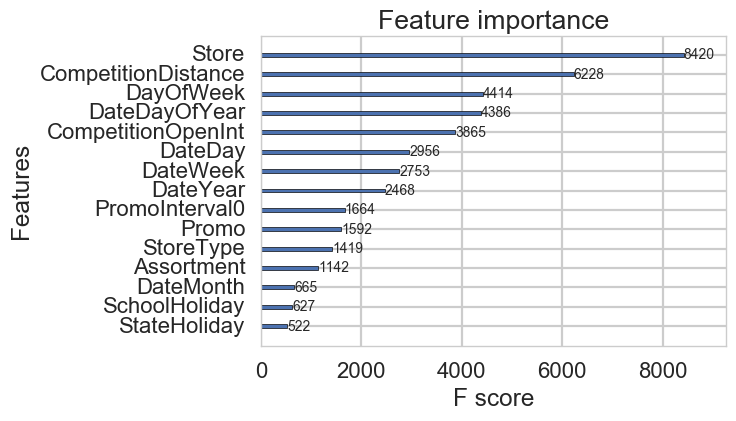

In [176]:
# Feature importance plot from XGBoost
xgb.plot_importance(bst)